## Beyond sporadic outbreaks: Classifying and explaining dengue endemicity over scenarios of global change.

*CPSC 581: Machine Learning*

*Yale University*

*Instructor: Alex Wong*

*Student: Hailey Robertson*

## Set up

#### Import packages

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
import sklearn.metrics as skmetrics
import sklearn.preprocessing as skpreprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge
from sklearn.cluster import KMeans, MeanShift
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd


# Geospatial
import geopandas as gpd
from shapely.geometry import MultiPolygon 
import country_converter as coco

# Other
import warnings
import json

warnings.filterwarnings(action='ignore')
np.random.seed(42)

#### Nice defaults for plotting

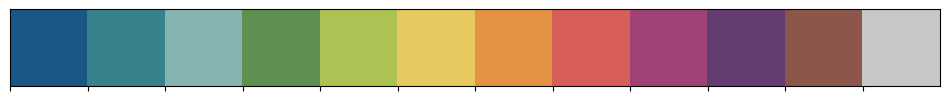

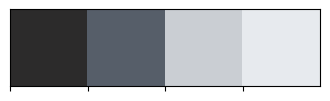

In [3]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# # Add every font at the specified location
# font_dir = ['/Users/haileyrobertson/Library/Fonts']
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 10

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Create data

#### Load Open Dengue and align country names

In [4]:
# --- Load dengue data ---
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
open_dengue = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

open_dengue["adm_0_iso3"] = coco.convert(
    names=open_dengue["adm_0_name"],
    to='ISO3',
    not_found="missing"
)

date_cols = ['calendar_start_date', 'calendar_end_date']
open_dengue[date_cols] = open_dengue[date_cols].apply(pd.to_datetime)
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year
open_dengue['month'] = open_dengue['calendar_start_date'].dt.month

#  Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# --- Load world geometry ---
world = gpd.read_file("../data/ne_110m_admin_0_countries")

world = world.rename(columns={
    "ADM0_A3": "adm_0_iso3",
    "ADMIN": "adm_0_name",
    "REGION_UN": "region_un",
    "geometry": "adm_0_geometry"
})[["adm_0_iso3", "adm_0_name", "region_un", "adm_0_geometry"]]

world = world.sort_values(by="adm_0_name")

# --- Fix known issues ---
# Split out French Guiana from France
france_idx = world['adm_0_name'] == 'France'
france_geom = world.loc[france_idx, 'adm_0_geometry'].values[0]

if isinstance(france_geom, MultiPolygon):
    polygons = list(france_geom.geoms)
    french_guiana_polygon = next((poly for poly in polygons if poly.bounds[0] < -50 and poly.bounds[2] > -54), None)

    if french_guiana_polygon:
        # Remove French Guiana from France
        remaining_polygons = [poly for poly in polygons if poly != french_guiana_polygon]
        world.loc[france_idx, 'adm_0_geometry'] = MultiPolygon(remaining_polygons)

        # Add French Guiana as separate entry
        french_guiana_row = {
            'adm_0_iso3': 'GUF',
            'adm_0_name': 'French Guiana',
            'region_un': 'Americas',
            'adm_0_geometry': french_guiana_polygon
        }
        world = pd.concat([world, gpd.GeoDataFrame([french_guiana_row], geometry='adm_0_geometry')], ignore_index=True)

# Patch ISO3 codes for special cases
world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'
world.loc[world['adm_0_name'] == 'South Sudan', 'adm_0_iso3'] = 'SSD'

# --- Merge dengue data with geometry ---
dengue = pd.merge(open_dengue, world, on='adm_0_iso3', how='outer', suffixes=('', '_world'))

# Fill UN regions with mapping
with open('../data/un_regions.json') as f:
    countries = json.load(f)
dengue['region_un'] = dengue['adm_0_iso3'].map(countries).fillna("Other")

# Aesthetics
dengue = dengue.drop(columns=['adm_0_name_world'])
front_cols = ['adm_0_name', 'adm_0_iso3']
geometry_col = ['adm_0_geometry']
other_cols = [col for col in dengue.columns if col not in front_cols + geometry_col]
dengue = dengue[front_cols + other_cols + geometry_col]

# Fill the years so that ISO3s stay as a time series
years = pd.Series(range(int(1950), int(dengue['year'].max()) + 1))
unique_iso3 = dengue['adm_0_iso3'].unique()

all_combinations = pd.MultiIndex.from_product([unique_iso3, years], names=['adm_0_iso3', 'year']).to_frame(index=False)

dengue_ts = all_combinations.merge(dengue, on=['adm_0_iso3', 'year'], how='outer')

# List of columns to fill
columns_to_fill = ['adm_0_name', 'region_un', 'adm_0_geometry']

# Fill NaN values for multiple columns
dengue_ts[columns_to_fill] = (
    dengue_ts
    .groupby('adm_0_iso3')[columns_to_fill]
    .transform(lambda x: x.ffill().bfill())
)

dengue_ts = dengue_ts.dropna(subset=['year'])

#### Load population first

In [5]:
# --- Clean population data ---
pop = pd.read_csv("../data/WPP2022_Demographic_Indicators_Medium.csv", dtype={'Time': int,'TPopulation1July':float}, low_memory=False)
columns = ['ISO3_code','Time','TPopulation1July']
pop = pop[columns]
pop.rename(columns={"ISO3_code": "adm_0_iso3", "Time": "year", "TPopulation1July": "TPopulation1July_per_1000"}, inplace=True)
pop['year'] = pd.to_numeric(pop['year'], errors='coerce').astype('Int64')
dengue_ts = dengue_ts.merge(pop, how='outer', on=['adm_0_iso3', 'year'])

#### Calculate incidence rates

In [6]:
grouped_df = dengue_ts.groupby(['adm_0_iso3', 
                                'year',
                                'region_un',
                                'TPopulation1July_per_1000'
                                ]).agg({
    'dengue_total': 'sum'
}).reset_index()

grouped_df['TPopulation1July'] = grouped_df['TPopulation1July_per_1000'] * 1000
grouped_df['incidence'] = grouped_df['dengue_total'] / grouped_df['TPopulation1July']
grouped_df['incidence_per_100k'] = grouped_df['incidence'] * 100000
grouped_df['log_incidence_per_100k'] = np.log1p(grouped_df['incidence_per_100k'])  # log(x + 1) to handle zero values

#### Load other predictors

In [7]:
# --- Clean population density ---
pop_dns = pd.read_csv("../data/pop_density_wb.csv")
year_cols = [col for col in pop_dns.columns if col.isdigit()]
pop_dns = pop_dns.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="pop_density_per_km2"
)
pop_dns.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)

# --- Clean climate data ---
clim = ['era5_tnn_annual_min_temp.csv', 'era5_tas_annual_mean_temp.csv', 'era5_pr_annual_mean_precipitation.csv', 'era5_hur_annual_mean_relative_humidity.csv']

climate_df = {}

for file in clim:
    data = pd.read_csv(f"../data/{file}")
    
    year_cols = [col for col in data.columns if col.startswith('19') or col.startswith('20')]

    melted = data.melt(
        id_vars=["code"],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )

    melted["year"] = melted["year"].str.extract(r"(\d{4})")
    melted.rename(columns={"code": "adm_0_iso3"}, inplace=True)
    indicator = file.replace('.csv', '')  
    melted.rename(columns={"value": indicator}, inplace=True)
    climate_df[indicator] = melted

# --- Clean urbanization data ---
urban = pd.read_csv("../data/urban_growth_wb.csv")

year_cols = [col for col in urban.columns if col.startswith('19') or col.startswith('20')]

urban = urban.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="urban_growth"
)
urban.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
urban['year'] = urban['year'].str.extract(r"(\d{4})")

# --- Clean urban pop data ---
u_pop = pd.read_csv("../data/urban_pop_wb.csv")

year_cols = [col for col in u_pop.columns if col.startswith('19') or col.startswith('20')]

u_pop = u_pop.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="urban_pop"
)
u_pop.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
u_pop['year'] = urban['year'].str.extract(r"(\d{4})")

# --- Clean GDP data ---
gdp = pd.read_csv("../data/gdp_ppp_wb.csv")

year_cols = [col for col in gdp.columns if col.startswith('19') or col.startswith('20')]

gdp = gdp.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="gdp_ppp"
)
gdp.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
gdp['year'] = gdp['year'].str.extract(r"(\d{4})")

# --- Clean arrivals data ---
arr = pd.read_csv("../data/tourism_arrivals_wb.csv")

year_cols = [col for col in arr.columns if col.startswith('19') or col.startswith('20')]

arr = arr.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="tourism_arrivals"
)
arr.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
arr['year'] = arr['year'].str.extract(r"(\d{4})")

# --- Clean departures data ---
dep = pd.read_csv("../data/tourism_departures_wb.csv")

year_cols = [col for col in dep.columns if col.startswith('19') or col.startswith('20')]

dep = dep.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="tourism_departures"
)
dep.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
dep['year'] = dep['year'].str.extract(r"(\d{4})")

In [8]:
predictor_dfs = [pop_dns, 
                 climate_df['era5_hur_annual_mean_relative_humidity'],
                 climate_df['era5_pr_annual_mean_precipitation'],
                 climate_df['era5_tas_annual_mean_temp'],
                 climate_df['era5_tnn_annual_min_temp'],
                 u_pop,
                 gdp,
                 arr,
                 dep]

merged_df = grouped_df.copy()

for i, predictor in enumerate(predictor_dfs):
    predictor['year'] = pd.to_numeric(predictor['year'], errors='coerce').astype('Int64')
    predictor = predictor.dropna(subset=['adm_0_iso3', 'year'])
    merged_df = merged_df.merge(predictor, how='outer', on=['adm_0_iso3', 'year'])

df = merged_df.replace('..', np.nan)
df = df[(df['year'] >= 1950) & (df['year'] <= 2022)]
df = df.dropna(subset=['region_un', 'adm_0_iso3', 'year'])
df.drop_duplicates(subset=['adm_0_iso3', 'year'], inplace=True)
print(df.columns)
print(df.shape)

df.to_csv('../output/data/cleaned_master_df.csv', index=False)


Index(['adm_0_iso3', 'year', 'region_un', 'TPopulation1July_per_1000',
       'dengue_total', 'TPopulation1July', 'incidence', 'incidence_per_100k',
       'log_incidence_per_100k', 'pop_density_per_km2',
       'era5_hur_annual_mean_relative_humidity',
       'era5_pr_annual_mean_precipitation', 'era5_tas_annual_mean_temp',
       'era5_tnn_annual_min_temp', 'urban_pop', 'gdp_ppp', 'tourism_arrivals',
       'tourism_departures'],
      dtype='object')
(15549, 18)


##### View data coverage

In [9]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
heatmap_data = df.pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)
print(len(heatmap_data))
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 1000))))

# Plot
fig, ax = plt.subplots(figsize=(10, 16))  

custom_colors = ["white", colors[1]]

# Plot the heatmap
im = sns.heatmap(data=heatmap_data, 
                 cmap=custom_cmap, 
                 annot=False, 
                 fmt='g', 
                 linewidths=0.1, 
                 ax=ax, 
                 vmin=0, 
                 vmax=1000, 
                 cbar=True, 
                 cbar_kws={'orientation': 'horizontal', 'pad': 0.04, 'label':'Incidence rate per 100,000'})

# Set tick labels and axis labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.set_title("Incidence rate per 100,000 over time",loc='left', fontsize=14)

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=6, width=10)
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index, fontsize=6)

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_1950-2023_full_covg.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

213


## Aim 1: Classify countries by endemicity status

### Check multicollinearity with VIF

In [22]:
# --- Load cleaned data ---
df = pd.read_csv('../output/data/cleaned_master_df.csv')

# --- VIF filtering ---
features = {
    'era5_tas_annual_mean_temp': 'Mean temperature (°C)',
    'era5_pr_annual_mean_precipitation': 'Mean precipitation (mm)',
    'era5_hur_annual_mean_relative_humidity': 'Mean relative humidity (%)',
    'urban_pop': 'Urban population (%)',
    'gdp_ppp': 'GDP per capita (PPP)',
    'tourism_arrivals': 'International tourism arrivals',
    'tourism_departures': 'International tourism departures',
    'pop_density_per_km2': 'Population density (people/km²)',
    'TPopulation1July': 'Population size',
    'log_incidence_per_100k':'Log incidence rate'
}

# --- Prepare VIF input (only rows without NaNs) ---
df_features = df[list(features.keys())].dropna().rename(columns=features)

# --- VIF Filtering Function ---
def calculate_vif(df, thresh=5):
    variables = df.copy()
    dropped = True
    while dropped:
        dropped = False
        vif = pd.DataFrame()
        vif["variable"] = variables.columns
        vif["VIF"] = [variance_inflation_factor(add_constant(variables).values, i + 1)
                      for i in range(variables.shape[1])]
        max_vif = vif["VIF"].max()
        if max_vif > thresh:
            drop_var = vif.sort_values("VIF", ascending=False)["variable"].iloc[0]
            print(f"Dropping '{drop_var}' with VIF = {max_vif:.2f}")
            variables = variables.drop(columns=[drop_var])
            dropped = True
        else:
            print(f"All variables have VIF < {thresh}")
    return variables

# --- Apply VIF filtering on clean subset ---
df_features_cleaned = calculate_vif(df_features)
cleaned_columns = df_features_cleaned.columns.tolist()

# Compute the correlation matrix
corr_matrix = df_features_cleaned.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../output/figures/correlation_matrix.png", dpi=300)
plt.close()


All variables have VIF < 5


### Cluster and plot functions

In [11]:
def scale_and_cluster(df, method='kmeans', n_clusters=3, random_state=42):
    """
    Scales the data and applies the selected clustering algorithm.

    Parameters:
        df (DataFrame): Input features.
        method (str): 'kmeans' or 'meanshift'.
        n_clusters (int): Used only if method is 'kmeans'.
        random_state (int): For reproducibility in kmeans.

    Returns:
        scaler, model, clusters, X_scaled
    """
    scaler = skpreprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(df)

    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=random_state)
    elif method == 'meanshift':
        model = MeanShift()
    else:
        raise ValueError("method must be 'kmeans' or 'meanshift'")

    clusters = model.fit_predict(X_scaled)
    sil_score = skmetrics.silhouette_score(X_scaled, clusters)
    print(f"{method.capitalize()} Silhouette Score: {sil_score:.3f}")
    
    return scaler, model, clusters, X_scaled

def plot_pca_clusters(X_scaled, cluster_labels, title, save_path, palette):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette=palette, s=50, legend='full')
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title='Cluster', loc='best')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def apply_model_to_full_data(df_full, cleaned_columns, scaler, model, cluster_col_name):
    df_imputed = df_full[cleaned_columns].copy()
    df_imputed = df_imputed.fillna(df_imputed.mean())
    X_scaled = scaler.transform(df_imputed)
    cluster_labels = model.predict(X_scaled)
    df_imputed[cluster_col_name] = cluster_labels
    return df_imputed

def save_cluster_labels(df, path):
    df.to_csv(path, index=False)

def plot_cluster_timeline(
    df,
    cluster_col='kmeans_cluster',
    x='year',
    y='adm_0_iso3',
    size='log_incidence_per_100k',
    title="Cluster membership over time by country",
    legend_labels=None,
    palette=None,
    save_path="timeline_cluster_plot.png",
    figsize=(20, 30),
    dpi=300,
    edgecolor='k'
):
    """
    Generates a timeline scatter plot of KMeans cluster assignments by country and year.

    Parameters:
        df (DataFrame): Data containing clustering results.
        cluster_col (str): Column name for cluster labels.
        x (str): Column to use for x-axis (typically 'year').
        y (str): Column to use for y-axis (typically country identifier).
        size (str): Column for bubble size (e.g., log incidence).
        title (str): Title of the plot.
        legend_labels (list of str): Custom labels for clusters.
        palette (dict): Mapping of cluster label to color.
        save_path (str): Path to save the output figure.
        figsize (tuple): Figure size.
        dpi (int): Resolution of output image.
        edgecolor (str): Edge color for the scatter dots.
    """
    if palette is None:
        unique_clusters = sorted(df[cluster_col].dropna().unique())
        default_colors = sns.color_palette(colors, len(unique_clusters))
        palette = {k: default_colors[i] for i, k in enumerate(unique_clusters)}

    plt.figure(figsize=figsize)

    scatter = sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=cluster_col,
        size=size,
        sizes=(1, 200),
        palette=palette,
        alpha=0.7,
        edgecolor=edgecolor,
        linewidth=0.5
    )

    plt.title(title, loc='left')
    plt.xlabel(x.capitalize())
    plt.ylabel(y.replace("_", " ").capitalize(), labelpad=10)

    # Extract legend handles
    handles, labels = scatter.get_legend_handles_labels()

    # Find where hue and size legends start
    hue_title_idx = labels.index(cluster_col)
    size_title_idx = labels.index(size)

    hue_handles = handles[hue_title_idx + 1:size_title_idx]
    size_handles = handles[size_title_idx + 1:]

    if legend_labels:
        hue_labels = legend_labels
    else:
        hue_labels = [f"Cluster {i}" for i in sorted(df[cluster_col].unique())]

    legend1 = plt.legend(
        handles=hue_handles,
        labels=hue_labels,
        title="Cluster",
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        handletextpad=0.4,
        borderaxespad=0.1,
        alignment='left'
    )

    legend2 = plt.legend(
        handles=size_handles,
        labels=labels[size_title_idx + 1:],
        title="Log incidence per 100k",
        loc='upper left',
        bbox_to_anchor=(1.02, 0.90),
        handletextpad=0.4,
        borderaxespad=0.1,
        alignment='left'
    )

    plt.gca().add_artist(legend1)

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.close()

#### K-Means clustering

In [12]:
# === 1. All Features ===
df_cleaned = df_features_cleaned.copy()
scaler, kmeans, clusters, X_scaled = scale_and_cluster(df_cleaned, method='kmeans', n_clusters=3)
df_cleaned['kmeans_cluster'] = clusters

plot_pca_clusters(
    X_scaled, 
    clusters, 
    "K-Means clusters in PCA space (All features)",
    "../output/figures/kmeans_pca_clusters_all_features.png", 
    colors[4:7]
)

df_full_imputed = apply_model_to_full_data(
    df_full=df[list(features.keys())].rename(columns=features), 
    cleaned_columns=features.values(), 
    scaler=scaler, 
    model=kmeans, 
    cluster_col_name='kmeans_cluster'
)
save_cluster_labels(df_full_imputed, "../output/data/all_features_kmeans_cluster_labels_by_country_year.csv")


# === 2. Incidence-Correlated Features ===
corr_features = {
    'era5_tas_annual_mean_temp': 'Mean temperature (°C)',
    'era5_pr_annual_mean_precipitation': 'Mean precipitation (mm)'
}
df_corr = df[list(corr_features.keys())].dropna().rename(columns=corr_features)

scaler, kmeans, clusters, X_scaled = scale_and_cluster(df_corr, method='kmeans', n_clusters=3)
df_corr['kmeans_cluster'] = clusters

plot_pca_clusters(
    X_scaled, 
    clusters, 
    "K-Means clusters in PCA space (Incidence-correlated features)",
    "../output/figures/kmeans_pca_clusters_incidence_correlated_features.png", 
    colors[4:7]
)

df_with_clusters = df.loc[df_corr.index, ['adm_0_iso3', 'year']].copy()
df_with_clusters['kmeans_cluster'] = clusters
df_with_clusters = df.merge(df_with_clusters, on=['adm_0_iso3', 'year'], how='left')

save_cluster_labels(df_with_clusters, "../output/data/incidence_correlated_kmeans_cluster_labels_by_country_year.csv")

cluster_palette = {0: colors[6], 1: colors[5], 2: colors[4]}
legend_labels = ["Endemic", "Hypo-endemic", "Non-endemic"]

plot_cluster_timeline(
    df=df_with_clusters,
    cluster_col='kmeans_cluster',
    x='year',
    y='adm_0_iso3',
    size='log_incidence_per_100k',
    title="Cluster membership over time by country (incidence correlated features)",
    legend_labels=legend_labels,
    palette=cluster_palette,
    save_path="../output/figures/incidence_correlated_timeline_kmeans_cluster_plot.png",
    dpi=1000
)


# === 3. Incidence Only ===
target_col = "log_incidence_per_100k"
df_inc = df[[target_col]].dropna()

scaler, kmeans, clusters, X_scaled = scale_and_cluster(df_inc, method='kmeans', n_clusters=3)
df_inc['kmeans_cluster'] = clusters

df_inc_imputed = df.copy()
df_inc_imputed[target_col] = df_inc_imputed[target_col].fillna(df_inc[target_col].mean())
X_full_scaled = scaler.transform(df_inc_imputed[[target_col]])
df_inc_imputed['kmeans_cluster'] = kmeans.predict(X_full_scaled)

save_cluster_labels(df_inc_imputed, "../output/data/incidence_kmeans_cluster_labels_by_country_year.csv")

cluster_palette = {0: colors[6], 1: colors[4], 2: colors[5]}
legend_labels = ["Endemic", "Non-endemic", "Hypo-endemic"]

plot_cluster_timeline(
    df=df_inc_imputed,
    cluster_col='kmeans_cluster',
    x='year',
    y='adm_0_iso3',
    size='log_incidence_per_100k',
    title="Cluster membership over time by country (incidence only)",
    legend_labels=legend_labels,
    palette=cluster_palette,
    save_path="../output/figures/incidence_timeline_kmeans_cluster_plot.png",
    dpi=1000
)


Kmeans Silhouette Score: 0.251
Kmeans Silhouette Score: 0.503
Kmeans Silhouette Score: 0.917


#### Mean shift clustering

In [14]:
# === 1. All Features ===
df_cleaned = df_features_cleaned.copy()
scaler, meanshift, clusters, X_scaled = scale_and_cluster(df_cleaned, method='meanshift')
df_cleaned['meanshift_cluster'] = clusters

plot_pca_clusters(
    X_scaled, 
    clusters, 
    "Meanshift clusters in PCA space (All features)",
    "../output/figures/meanshift_pca_clusters_all_features.png", 
    colors[::2]
)

df_full_imputed = apply_model_to_full_data(
    df_full=df[list(features.keys())].rename(columns=features), 
    cleaned_columns=features.values(), 
    scaler=scaler, 
    model=meanshift, 
    cluster_col_name='meanshift_cluster'
)
save_cluster_labels(df_full_imputed, "../output/data/all_features_meanshift_cluster_labels_by_country_year.csv")

# === 2. Incidence-Correlated Features ===
corr_features = {
    'era5_tas_annual_mean_temp': 'Mean temperature (°C)',
    'era5_pr_annual_mean_precipitation': 'Mean precipitation (mm)'
}
df_corr = df[list(corr_features.keys())].dropna().rename(columns=corr_features)

scaler, meanshift, clusters, X_scaled = scale_and_cluster(df_corr, method='meanshift')
df_corr['meanshift_cluster'] = clusters

plot_pca_clusters(
    X_scaled, 
    clusters, 
    "Meanshift clusters in PCA space (Incidence-correlated features)",
    "../output/figures/meanshift_pca_clusters_incidence_correlated_features.png", 
    colors[4:7]
)

df_with_clusters = df.loc[df_corr.index, ['adm_0_iso3', 'year']].copy()
df_with_clusters['meanshift_cluster'] = clusters
df_with_clusters = df.merge(df_with_clusters, on=['adm_0_iso3', 'year'], how='left')

save_cluster_labels(df_with_clusters, "../output/data/incidence_correlated_meanshift_cluster_labels_by_country_year.csv")

cluster_palette = {0: colors[6], 1: colors[5], 2: colors[4]}
legend_labels = ["Endemic", "Hypo-endemic", "Non-endemic"]

plot_cluster_timeline(
    df=df_with_clusters,
    cluster_col='meanshift_cluster',
    x='year',
    y='adm_0_iso3',
    size='log_incidence_per_100k',
    title="Cluster membership over time by country (incidence correlated features)",
    legend_labels=legend_labels,
    palette=cluster_palette,
    save_path="../output/figures/incidence_correlated_timeline_meanshift_cluster_plot.png",
    dpi=1000
)

# === 3. Incidence Only ===
target_col = "log_incidence_per_100k"
df_inc = df[[target_col]].dropna()

scaler, meanshift, clusters, X_scaled = scale_and_cluster(df_inc, method='meanshift')
df_inc['meanshift_cluster'] = clusters

df_inc_imputed = df.copy()
df_inc_imputed[target_col] = df_inc_imputed[target_col].fillna(df_inc[target_col].mean())
X_full_scaled = scaler.transform(df_inc_imputed[[target_col]])
df_inc_imputed['meanshift_cluster'] = meanshift.predict(X_full_scaled)

save_cluster_labels(df_inc_imputed, "../output/data/incidence_meanshift_cluster_labels_by_country_year.csv")

plot_cluster_timeline(
    df=df_inc_imputed,
    cluster_col='meanshift_cluster',
    x='year',
    y='adm_0_iso3',
    size='log_incidence_per_100k',
    title="Cluster membership over time by country (incidence only)",
    legend_labels=None,
    palette=None,
    save_path="../output/figures/incidence_timeline_meanshift_cluster_plot.png",
    dpi=1000
)


Meanshift Silhouette Score: 0.430
Meanshift Silhouette Score: 0.439
Meanshift Silhouette Score: 0.911


## Aim 2: Predict endemicity status

### Predict class

In [27]:
# Use incidence only version to prevent data leakage
df_with_labels = pd.read_csv('../output/data/incidence_kmeans_cluster_labels_by_country_year.csv')

In [28]:
# --- Preprocess data ---
target = 'kmeans_cluster'
class_features = [
    'TPopulation1July',
    'pop_density_per_km2',
    'era5_hur_annual_mean_relative_humidity',
    'era5_pr_annual_mean_precipitation', 
    'era5_tas_annual_mean_temp',
    'era5_tnn_annual_min_temp', 
    'urban_pop', 
    'gdp_ppp', 
    'tourism_arrivals',
    'tourism_departures'
]

df_model = df_with_labels[df_with_labels[target].notna()].copy()
X = df_model[class_features]
y = df_model[target].astype(int)

y_unique = np.unique(y)
y_names = ['Endemic', 'Non-endemic', 'Hypo-endemic'] 

print("Preprocessing data ({} samples, {} feature dimensions)".format(X.shape[0], X.shape[1]))

shuffled_indices = np.random.permutation(len(X))

train_split_idx = int(0.8 * len(X))

train_indices = shuffled_indices[0:train_split_idx]
val_indices = shuffled_indices[train_split_idx:]

# Select the examples from X and y to construct our training, validation, testing sets
X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]

# --- Impute missing values in training and validation data ---
imputer = SimpleImputer(fill_value=-999, strategy='constant') 
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# --- Apply Standard Scaling ---
scaler = skpreprocessing.StandardScaler()
X_train_class_scaled = scaler.fit_transform(X_train_imputed)
X_val_class_scaled = scaler.transform(X_val_imputed)

# --- Train and validate model ---

class_model = LogisticRegression(
    class_weight='balanced',  
    penalty='l2',             
    C=1.0,                    
    solver='liblinear'        
)
class_model.fit(X_train_class_scaled, y_train)

predictions_train = class_model.predict(X_train_class_scaled)
score_train = skmetrics.accuracy_score(y_train, predictions_train)
print('Training set mean accuracy: {:.4f}'.format(score_train))

predictions_val = class_model.predict(X_val_class_scaled)
score_val = skmetrics.accuracy_score(y_val, predictions_val)
print('Validation set mean accuracy: {:.4f}'.format(score_val))

# --- Confusion matrix ---
confusion_matrix = skmetrics.confusion_matrix(y_val, predictions_val)

confusion_matrix_plot = skmetrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_names)

confusion_matrix_plot.plot()

plt.savefig("../output/figures/confusion_matrix_all_features.png", dpi=300, bbox_inches='tight')
plt.close()

# --- ROC curve ---

probabilities_val = class_model.predict_proba(X_val_class_scaled)

fig = plt.figure(figsize=figure_size)
ax = fig.add_subplot(111)

one_hot_val = skpreprocessing.label_binarize(y_val, classes=y_unique)

for class_id, color, label in zip(range(len(y_unique)), colors[4:7][::-1], y_names):
    skmetrics.RocCurveDisplay.from_predictions(
        one_hot_val[:, class_id],
        probabilities_val[:, class_id],
        name=f"ROC curve for {label}",
        color=color,
        ax=ax
    )
plt.savefig("../output/figures/roc_curve_all_features.png", dpi=300, bbox_inches='tight')
plt.close()

# --- SGD comparison ---
sgd_model = SGDClassifier(
    loss='log_loss',              
    eta0=1e-3,
    penalty='l2',                 
    class_weight='balanced',      
    max_iter=5000,
    random_state=42
)
sgd_model.fit(X_train_class_scaled, y_train)

sgd_val_predictions = sgd_model.predict(X_val_class_scaled)
sgd_val_accuracy = skmetrics.accuracy_score(y_val, sgd_val_predictions)
print("SGD logistic regression validation accuracy: {:.4f}".format(sgd_val_accuracy))

# --- Compare accuracies ---
models = ['LogisticRegression', 'SGDClassifier']
accuracies = [score_val, sgd_val_accuracy]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=[colors[1], colors[6]])
plt.ylim(0, 1.1)
plt.axhline(0.70, color=chart[0], linestyle='--', linewidth=1, label='Target accuracy (0.70)')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.savefig("../output/figures/validation_accuracy_comparison_all_features.png", dpi=300)
plt.close()

Preprocessing data (15549 samples, 10 feature dimensions)
Training set mean accuracy: 0.8055
Validation set mean accuracy: 0.8138
SGD logistic regression validation accuracy: 0.8132


### BONUS: Predict incidence

In [35]:
# --- Preprocess data ---
target = 'log_incidence_per_100k'  
incidence_features = [
    'TPopulation1July',
    'pop_density_per_km2',
    'era5_hur_annual_mean_relative_humidity',
    'era5_pr_annual_mean_precipitation', 
    'era5_tas_annual_mean_temp',
    'era5_tnn_annual_min_temp', 
    'urban_pop', 
    'gdp_ppp', 
    'tourism_arrivals',
    'tourism_departures'
]

df_model = df_with_labels[df_with_labels[target].notna()].copy()
X = df_model[incidence_features]
y = df_model[target]

# Train-test split
shuffled_indices = np.random.permutation(len(X))
train_split_idx = int(0.8 * len(X))
train_indices = shuffled_indices[:train_split_idx]
val_indices = shuffled_indices[train_split_idx:]

X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]

# Impute missing values 
imputer = SimpleImputer(fill_value=-999, strategy='constant')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# --- Generate polynomial features ---
poly = skpreprocessing.PolynomialFeatures(degree=3, include_bias=True)  
X_train_poly = poly.fit_transform(X_train_imputed)
poly_feature_names = poly.get_feature_names_out().tolist()
X_val_poly = poly.transform(X_val_imputed)

# --- Scale ---
scaler = skpreprocessing.StandardScaler()
X_train_incidence_scaled = scaler.fit_transform(X_train_poly)
X_val_incidence_scaled = scaler.transform(X_val_poly)

# --- Fit polynomial regression ---
incidence_model = Ridge(alpha=1.0)
incidence_model.fit(X_train_incidence_scaled, y_train)

# --- Training Predictions ---
train_predictions = incidence_model.predict(X_train_incidence_scaled)

# --- Training Evaluation ---
train_mse = skmetrics.mean_squared_error(y_train, train_predictions)
train_r2 = skmetrics.r2_score(y_train, train_predictions)

print(f"Train MSE: {train_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")


# --- Predictions ---
val_predictions = incidence_model.predict(X_val_incidence_scaled)

# --- Evaluate ---
mse = skmetrics.mean_squared_error(y_val, val_predictions)
r2 = skmetrics.r2_score(y_val, val_predictions)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R^2: {r2:.4f}")

# --- Residuals ---
residuals = y_val - val_predictions

# Residual plot
plt.figure(figsize=(8,6))
plt.scatter(val_predictions, residuals, alpha=0.6, edgecolor=chart[1], c=colors[0])
plt.axhline(0, color=colors[8], linestyle='--', linewidth=1)
plt.xlabel('Predicted Log Incidence per 100k')
plt.ylabel('Residuals')
plt.title('Residual Plot (Polynomial Regression)')
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/figures/residuals_poly_regression_all_features.png", dpi=300)
plt.close()

# Residual distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color=colors[0])
plt.axvline(0, color=colors[8], linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("../output/figures/residual_distribution_poly_regression_all_features.png", dpi=300)
plt.close()

Train MSE: 1.5660
Train R^2: 0.3814
Validation MSE: 1.6220
Validation R^2: 0.3486


#### Predict incidence for 2023

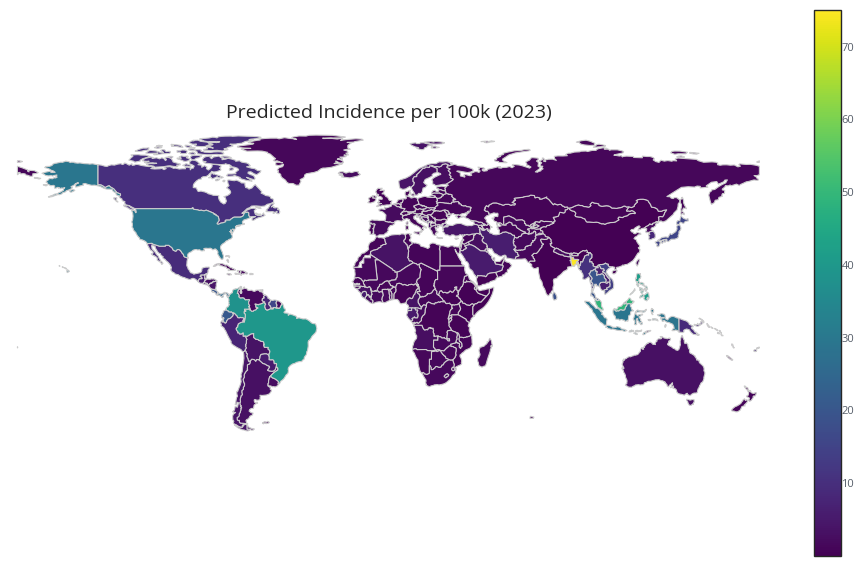

In [97]:
future_years = merged_df['year'].isin([2023])
df_future = merged_df[future_years].copy()
X_future = df_future[incidence_features]

X_future_imputed = imputer.transform(X_future)
X_future_poly = poly.transform(X_future_imputed)
X_future_scaled = scaler.transform(X_future_poly)

future_predictions = incidence_model.predict(X_future_scaled)
df_future['predicted_log_incidence_per_100k'] = future_predictions


residual_std = np.std(residuals)

z = stats.norm.ppf(0.975)
ci_margin = z * residual_std

df_future['ci_lower'] = future_predictions - ci_margin
df_future['ci_upper'] = future_predictions + ci_margin

df_future['predicted_incidence_per_100k'] = np.exp(df_future['predicted_log_incidence_per_100k'])
df_future['ci_lower_incidence'] = np.exp(df_future['ci_lower'])
df_future['ci_upper_incidence'] = np.exp(df_future['ci_upper'])

map_2023 = world.merge(df_future, left_on='adm_0_iso3', right_on='adm_0_iso3')
map_2023 = gpd.GeoDataFrame(map_2023, geometry='adm_0_geometry')

fig, ax = plt.subplots(figsize=(10, 6))

vmin = map_2023['predicted_incidence_per_100k'].min()
vmax = map_2023['predicted_incidence_per_100k'].max()
# norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot with centered color scale
map_2023.plot(
    column='predicted_incidence_per_100k',
    cmap='viridis',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={
        'color': 'lightgrey',
        'label': 'No data'
    }
)


ax.set_title('Predicted Incidence per 100k (2023)', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.savefig("../output/figures/predicted_incidence_map_2023.png", dpi=300)
plt.show()



## Aim 3: Use explainable AI to interpret predictions

In [29]:
model = class_model
explainer = shap.Explainer(model, X_train_class_scaled)
shap_values = explainer(X_val_class_scaled)

plt.figure(figsize=(8, 16))
shap.summary_plot(shap_values, X_val_class_scaled, feature_names=class_features, show=False)

# Customize axis labels
plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Save the figure
plt.legend(loc='lower right')  # only needed if your plot includes color legend
plt.savefig('../output/figures/classification_shap_values.png', dpi=300, bbox_inches='tight')
plt.close()